<a href="https://colab.research.google.com/github/the-SQuAD-squad/IR/blob/tfidf/IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install wikipedia-api

  Created wheel for wikipedia-api: filename=Wikipedia_API-0.5.4-cp37-none-any.whl size=13462 sha256=59154e35eee862cee3bcdc475b5263d0150d8d369f0d64476c7785c64423a37f
  Stored in directory: /root/.cache/pip/wheels/bf/40/42/ba1d497f3712281b659dd65b566fc868035c859239571a725a
Successfully built wikipedia-api


In [38]:
import wikipediaapi

# Get all links in a wiki page
wiki_wiki = wikipediaapi.Wikipedia('en')
page_py = wiki_wiki.page("Python (programming language)")
def get_links(page):
    links = page.links
    for title in sorted(links.keys()):
        if links[title].ns != 0 or "Unauthorized" in title or "Being Tom Cruise" in title:
            links.pop(title)
    return links

links = get_links(page_py)

In [ ]:
from tqdm.notebook import tqdm
pages_text = {}
for title in tqdm(links):
    page_py = links[title]
    pages_text[title] = page_py.text

pages_text

In [ ]:
for title in pages_text:
    stop_index = pages_text[title].rfind("References")
    pages_text[title] = pages_text[title][:stop_index]

In [5]:
#@title Init { form-width: "25%" }
import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import re
import string
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

!pip install tokenizers
from tokenizers import BertWordPieceTokenizer

from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# BERT params
max_seq_length = 512
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)


     |████████████████████████████████| 3.2MB 6.0MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [6]:
#@title df creation { form-width: "25%" }

# the official dataset is identical to the provided one
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O training_set.json

with open("training_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_original = pd.DataFrame(rows)

--2021-03-03 17:21:38--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘training_set.json’

training_set.json   100%[===================>]  28.88M  50.0MB/s    in 0.6s    

2021-03-03 17:21:41 (50.0 MB/s) - ‘training_set.json’ saved [30288272/30288272]



In [ ]:
#@title preprocessing { form-width: "25%" }

import nltk
import re 
import math
import random as rand

nltk.download('punkt')
from nltk.stem.porter import PorterStemmer # for stemming

from tqdm.notebook import tqdm


def preprocess_text(text):
    """
    Given an iterable containing sentences, pre-process each sentence.

    :param: 
        - text: list of text to be pre-processed (Iterable)
    :return:
        - text: pre-processed text (List)
    """

    REPLACE_WITH_SPACE = re.compile(r"\n") 
    text = [REPLACE_WITH_SPACE.sub(" ", line) for line in text]

    # we don't remove symbols, but just put a space before and after them. We did this because we noticed that Glove contains an embedding also for
    # them, so, in this way, we are able to split these symbols from the text when computing sentence tokens
    text = [re.sub(r"([(.;:!\'ˈ~?,\"(\[\])\\\/\-–\t```<>_#$€@%*+—°′″“”×’^₤₹‘])", r'', line) for line in text]

    # we noticed that in the text sometimes we find numbers and the following word merged together (ex: 1980february),
    # so we put a space between the number and the word
    text = [re.sub(r"(\d+)([a-z]+)", r'\1 \2', line) for line in text] 
    text = [re.sub('\s{2,}', ' ', line.strip()) for line in text]   # replacing more than one consecutive blank spaces with only one of them

    return text

    stemmed_lines = []
    for line in tqdm(text):
        tokens = nltk.word_tokenize(line)
        stems = []
        for item in tokens:
            stems.append(PorterStemmer().stem(item))
        stemmed_lines.append(' '.join(stems))

    return stemmed_lines

# Creating a copy of the original dataframe (we do this because we want to be able to compare the results of our processing with the original data)
df = df_original.copy()

# pre-process passage and question text
df['passage'] = preprocess_text(df_original['passage'])
df['question'] = preprocess_text(df_original['question'])
df['answer_text'] = preprocess_text(df_original['answer_text'])


# Comparing Original and Pre-Processed
for i in range(3):
    a = rand.randint(0,1000)
    print('ORIGINAL AND PREPROCESSED PASSAGE:')
    print(df_original.iloc[a]['passage'])
    print(df.iloc[a]['passage'])
    
    print()
    print('ORIGINAL AND PREPROCESSED QUESTION:')
    print(df_original.iloc[a]['question'])
    print(df.iloc[a]['question'])
    print()

In [42]:
# PREPROCESS TOM CRUISE
pages_text_preprocessed = preprocess_text(pages_text.values())
titles = list(pages_text.keys())
print(len(pages_text))
print(len(pages_text_preprocessed))
print(len(titles))

741
741
741


In [9]:
df["passage"]=df["passage"].str.lower()
df["question"]=df["question"].str.lower()
df["answer_text"]=df["answer_text"].str.lower()

In [10]:
#@title clean dataset { form-width: "25%" }

!gcloud config set project feisty-mechanic-221914
!gsutil cp gs://squad_squad/error_IDs.txt ./error_IDs.txt

with open("error_IDs.txt", "r") as f:
    unwanted_id = f.read()

unwanted_id = unwanted_id.split("\n")[:-1]
df_clean = df.set_index('id')
df_clean = df_clean.drop(unwanted_id)

df_original_clean = df_original.set_index('id')
df_original_clean = df_original_clean.drop(unwanted_id)

Updated property [core/project].
Copying gs://squad_squad/error_IDs.txt...
/ [1 files][  5.7 KiB/  5.7 KiB]                                                
Operation completed over 1 objects/5.7 KiB.                                      


In [11]:
#@title split { form-width: "25%" }

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

split_value = 0.1 #@param {type:"number"} 
val_dim = int(len(df_clean['title'].unique()) * split_value)
test_titles = np.random.choice(df_clean['title'].unique(), size=val_dim, replace=False)

# creating train and val sets
df_test = df_clean[df_clean['title'].isin(test_titles)]
df_train = df_clean[~(df_clean['title'].isin(test_titles))]

df_original_test = df_original_clean[df_original_clean['title'].isin(test_titles)]
df_original_train = df_original_clean[~(df_original_clean['title'].isin(test_titles))]

In [12]:
passage_prep_train = df_train['passage'].unique().tolist()
passage_train = df_original_train['passage'].unique().tolist()

In [13]:
vectorizer =  TfidfVectorizer()
# tokenization and creation of Bag of Words representation
passage_tf_idf = vectorizer.fit_transform(passage_prep_train)

# we keep track of the original passage index before performing unique()

passage_prep_test = df_test['passage'].unique().tolist() # preprocessed
passage_test = df_original_test['passage'].unique()      # original

passage_test_tf_idf = vectorizer.transform(passage_prep_test)
question_tf_idf = vectorizer.transform(df_test['question'].tolist())

results = cosine_similarity(passage_test_tf_idf, question_tf_idf)


[0.5450475657526581, 0.6624230554001119, 0.7250979294907667]


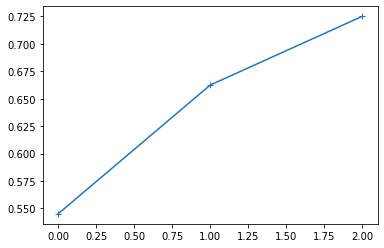

In [14]:
# single passage scores
k_results = 3

tp = 0 #true positives
accuracy = []
for k in tqdm(range(1, k_results+1)):
    for j,result in enumerate(results.T):
        result = np.argsort(result)
        if df_original_test['passage'].tolist()[j] in [text for text in passage_test[result[-k:].tolist()]]:
            tp+=1
    accuracy.append(tp/len(df_original_test))
    tp = 0

print(accuracy,sep='\n')
plt.plot(accuracy,"-+");


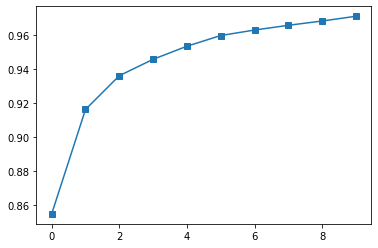

In [ ]:
# full document scores
passage_group = df_original_test.groupby('passage').groups

k_results = 15
tp = 0
document_accuracy = []
for k in tqdm(range(1,11)):
    for j,result in enumerate(results.T):
        result = np.argsort(result)
        for h in range(1,k+1):
            if df_original_test.loc[passage_group[df_original_test['passage'].tolist()[j]][0]]['title'] == df_original_test.loc[passage_group[passage_test[result[-h]]][0]]['title']:
                tp+=1
                break
    document_accuracy.append(tp/len(df_original_test))
    tp = 0

plt.plot(document_accuracy,"-s")

In [49]:
# TOM CRUISE RETRIEVAL
vectorizer =  TfidfVectorizer()

questions = ["When was Tom Cruise born?", "What was the first film Tom Cruise acted in?", "What does Tom Cruise believe in?", "What is Tom Cruise character's name in Mission Impossible?", "What is Vanilla Sky?", "Who directed Mission Impossible?"]
passages_vectorized = vectorizer.fit_transform(pages_text_preprocessed)
questions_vectorized = vectorizer.transform(questions)

results = cosine_similarity(questions_vectorized,passages_vectorized)


for i,row in enumerate(results):
    index = np.argmax(row)
    print(questions[i], end = " ---> ")
    print(titles[index])

When was Tom Cruise born? ---> Stuart J. Russell
What was the first film Tom Cruise acted in? ---> Revolution OS
What does Tom Cruise believe in? ---> Viral license
What is Tom Cruise character's name in Mission Impossible? ---> Escape character
What is Vanilla Sky? ---> Cinema 4D
Who directed Mission Impossible? ---> NASA


# BERT QA



In [ ]:
"""
#@title Init { form-width: "25%" }
import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import re
import string
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

!pip install tokenizers
from tokenizers import BertWordPieceTokenizer

!pip install transformers
import transformers
from transformers import AutoTokenizer
pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# BERT params
max_seq_length = 512
# Huggingface bert and associated tokenizer
#pretrained_model_str = "google/electra-small-discriminator"#
#bert_hf_layer = transformers.TFElectraModel.from_pretrained(
#    pretrained_model_str, output_attentions=True)

pretrained_model_str = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_str)

bert_hf_layer = transformers.TFRobertaModel.from_pretrained(
    pretrained_model_str, output_attentions=True)
"""

'\n#@title Init { form-width: "25%" }\nimport os\nimport random\nimport math\nimport numpy as np\nimport tensorflow as tf\nimport json\nimport pandas as pd\nimport re\nimport string\nimport tensorflow_hub as hub\nfrom tensorflow import keras\nfrom tensorflow.keras import layers\n\n!pip install tokenizers\nfrom tokenizers import BertWordPieceTokenizer\n\n!pip install transformers\nimport transformers\nfrom transformers import AutoTokenizer\npd.set_option(\'display.max_colwidth\', -1)\n\n# fix random seeds\nseed_value = 42 #@param {type:"integer"}\n\nos.environ[\'PYTHONHASHSEED\']=str(seed_value)\nrandom.seed(seed_value)\nnp.random.seed(seed_value)\n\ntf.compat.v1.set_random_seed(seed_value)\n\nsession_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)\nsess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)\ntf.compat.v1.keras.backend.set_session(sess)\n\n# BERT params\nmax_seq_length = 512\n# Huggingface bert

In [ ]:
# IR-QA
# che vogliamo fa?

# se vogliamo che il sistema IRQA funzioni con domande a caso, tipo Tom Cruise
# allora dobbiamo preprocessare con il BERT tokenizer tutti i passage che ci da fuori TF-IDF.
# perchè servono le attention mask e via.

# però per valutare il sistema IRQA sulla risposta corretta come facciamo per QA
# dobbiamo confrontare con la risposta corretta nel dataset preprocessato da bert.
# Ovviamente questo si può fare solo per validation set (validation di bert che si chiama test qui su IR) e
# anche per dev set con lo script di evaluate, anche se è più un macello, forse.

# Io direi di portare qui il dataset bert_preprocessed
# e ritrovare il passage che ci da fuori IR in questo dataset.
# In questo modo abbiamo la riga, quindi i token giusti della risposta.



In [ ]:
"""
question_tf_idf = vectorizer.transform(df_test['question'].tolist())

results = cosine_similarity(passage_test_tf_idf, question_tf_idf)

passage_test[np.argsort(result)[:5]]
"""


"\nquestion_tf_idf = vectorizer.transform(df_test['question'].tolist())\n\nresults = cosine_similarity(passage_test_tf_idf, question_tf_idf)\n\npassage_test[np.argsort(result)[:5]]\n"

# GET READY FOR THE CRUISE NET

In [ ]:
#@title model definition { form-width: "25%" }

!pip install transformers > /dev/null
import transformers

pretrained_model_str = "roberta-base"
bert_hf_layer = transformers.TFRobertaModel.from_pretrained(
    pretrained_model_str, output_attentions=True)

#@title model definition { form-width: "25%" }

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_type_ids')

#pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

#HUGGINGFACE 🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗
sequence_output = bert_hf_layer(input_ids=input_word_ids, attention_mask=input_mask, 
                                token_type_ids=input_type_ids).last_hidden_state

#do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

start_logits = layers.Dense(1, name="start_logit", use_bias=False)(sequence_output)
start_logits = layers.Flatten(name="flatten_start")(start_logits)

end_logits = layers.Dense(1, name="end_logit", use_bias=False)(sequence_output)
end_logits = layers.Flatten(name="flatten_end")(end_logits)

start_probs = layers.Activation(keras.activations.softmax, name="softmax_start")(start_logits)
end_probs = layers.Activation(keras.activations.softmax, name="softmax_end")(end_logits)

model = keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], 
                    outputs=[start_probs, end_probs],
                    name="BERT_QA")

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

optimizer = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.summary(line_length=150)


!wget https://api.wandb.ai/files/buio/SQUAD/jkgwaatn/model-best.h5
model.load_weights("model-best.h5")

In [17]:
import nltk.data

from  transformers import AutoTokenizer

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy().decode("utf-8")
#tokenizer = BertWordPieceTokenizer(vocab=vocab_file, lowercase=True)

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_str)
max_seq_length = 512

def preprocess_bert(text):
    tokenized_text = tokenizer(text, return_offsets_mapping=True)

    rows_out = tokenized_text.input_ids

    return rows_out

def custom_inference(context, question):
    tokenizer_nltk = nltk.data.load('tokenizers/punkt/english.pickle')  # sentence tokenizer
    context_sentences = tokenizer_nltk.tokenize(context)
    preprocessed_context = [" ".join(str(line).split()) for line in context_sentences]
    preprocessed_question = " ".join(str(question).split())
    tokenized_question = preprocess_bert(preprocessed_question)
    tokenized_sentences = [preprocess_bert(preprocessed_line) for preprocessed_line in preprocessed_context]
    sentence_index = 0
    tokenized_passages = []

    while sentence_index < len(tokenized_sentences):
        start = sentence_index
        len_count = len(tokenized_question)
        while len_count <= 512 and sentence_index < len(tokenized_sentences):
            len_count += len(tokenized_sentences[sentence_index])
            sentence_index += 1
        end = sentence_index -1
        tokenized_passages.append(preprocess_bert(" ".join(preprocessed_context[start:end])))

    prob = []
    candidate_ans = []
    for tokenized_passage in tokenized_passages:
        input_ids = tokenized_passage + tokenized_question[1:]
        token_type_ids = [0] * len(tokenized_passage) + [1] * len(tokenized_question[1:])
        attention_mask = [1] * len(input_ids)
        padding_length = max_seq_length - len(input_ids)
        if padding_length > 0:
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        input_word_ids = np.array(input_ids)
        input_mask = np.array(attention_mask)
        input_type_ids = np.array(token_type_ids)
        predictions = model.predict([np.expand_dims(input_word_ids, axis =0), 
                                    np.expand_dims(input_mask, axis = 0), 
                                    np.expand_dims(input_type_ids,axis=0)])
        start, end = list(np.argmax(predictions, axis=-1).squeeze())
        if start > end:
            continue 
        else:
            prob_start,prob_end = list(np.max(predictions, axis=-1).squeeze())
            prob_sum = prob_start+prob_end
            predicted_ans = tokenizer.decode(tokenized_passage[start : end+1])
            if predicted_ans != '' and predicted_ans != "<s>":
                candidate_ans.append(predicted_ans)
                prob.append(prob_sum)

    print(*zip(prob, candidate_ans), sep='\n')  
    try:     
        ans = candidate_ans[np.argmax(prob)]
    except:
        ans = "I'm really sorry, I wasn't able to find an answer :("
    return ans

In [51]:
questions = ["Who is the first bride of Tom Cruise?", "When was Tom Cruise born?", "What is Mission Impossible?", "What does Tom Cruise believe in?", "What is the genre of Mission Impossible?", "Who is the villain in Mission impossible 3?", "Who is the villain in Mission impossible ghost protocol?" "What is Tom Cruise character's name in Mission Impossible III?", "What is Vanilla Sky?", "Who directed Mission Impossible?"]
question = "what type of programming language is python?"
question_vectorized = vectorizer.transform([question])
result = cosine_similarity(question_vectorized,passages_vectorized)
index = np.argmax(result[0])
print("TF-IDF result:")
print(question, end = " ---> ")
print(titles[index])
context = pages_text[titles[index]]
predicted_ans = custom_inference(context,question)
print()
print("BERT answer:")
print(predicted_ans)

TF-IDF result:
what type of programming language is python? ---> Dynamic type


BERT answer:
I'm really sorry, I wasn't able to find an answer :(
